<a href="https://colab.research.google.com/github/tonywangs/cs131-final-project/blob/main/Copy_of_131_alternative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2 as cv
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
! pip install torch torchvision matplotlib numpy
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp /root/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download frlemarchand/nfl-player-numbers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!zip -T nfl-player-numbers.zip

test of nfl-player-numbers.zip OK


In [3]:
! unzip nfl-player-numbers.zip -d nfl_data

Streaming output truncated to the last 5000 lines.
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_360_V90.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_H6.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_H64.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_H77.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_H78.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_H80.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_H85.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_H89.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_V23.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_V30.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_V50.png  
  inflating: nfl_data/train_player_numbers/58095_004022_Endzone_380_V57.png  
  inflating: n

In [4]:
print(os.path.abspath("nfl-player-numbers.zip"))

/content/nfl-player-numbers.zip


In [5]:
import zipfile

zip_file_path = '/content/nfl-player-numbers.zip'
extract_to_folder = '/content/nfl_data'  # Choose your desired extraction path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_folder)

print(f"Files extracted to: {extract_to_folder}")

Files extracted to: /content/nfl_data


Detected Number: 1, Confidence: 0.9524594440105751, Bounding Box: [[0, 0], [22, 0], [22, 32], [0, 32]]


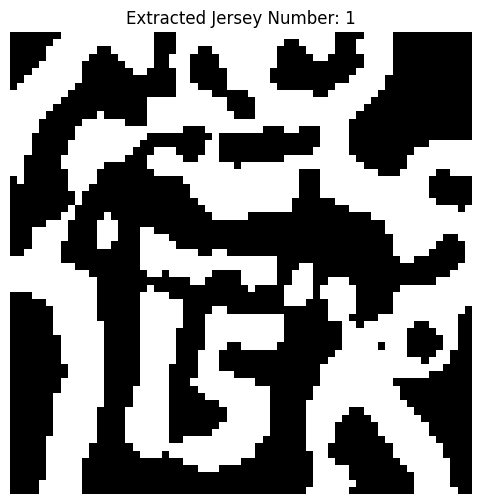

Detected Jersey Number: 1


In [25]:
!pip install easyocr
import cv2
import easyocr
import numpy as np
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'


def preprocess_image(image_path):
    """Loads and preprocesses the image while preserving color contrast."""
    # Load the image in color
    image = cv2.imread(image_path)

    # Convert image to HSV (Hue, Saturation, Value) to filter numbers based on color contrast
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define lower and upper bounds for filtering based on color contrast
    lower_bound = np.array([0, 0, 120], dtype=np.uint8)  # Adjust based on jersey color
    upper_bound = np.array([180, 60, 255], dtype=np.uint8)

    # Create a mask to filter out the jersey background and keep only high-contrast numbers
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Bitwise-AND to keep only the number part
    filtered = cv2.bitwise_and(image, image, mask=mask)

    # Convert to grayscale while keeping enhanced contrast
    gray = cv2.cvtColor(filtered, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # Use adaptive thresholding to highlight the numbers
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    return thresh

def extract_jersey_number(image):
    """Extracts the jersey number from the processed image using OCR."""
    height, width = image.shape

    # Define region of interest (ROI) where the number is likely to be
    roi = image[int(height * 0.5):, int(width * 0.3):int(width * 0.7)]

    # Apply morphological operations to clean noise
    kernel = np.ones((3, 3), np.uint8)
    roi = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)

    # Apply edge detection to sharpen the digits
    edges = cv2.Canny(roi, 50, 150)

    # Use Tesseract OCR to extract the number (only digits allowed)
    # extracted_text = pytesseract.image_to_string(
    #     edges, config="--psm 6 --oem 1 -c tessedit_char_whitelist=0123456789"
    # )
    reader = easyocr.Reader(['en'])
    result = reader.readtext(edges, allowlist ='0123456789')

    import re

    # Extract only numbers from detected text
    numbers = [(bbox, text, confidence) for bbox, text, confidence in result if re.fullmatch(r'\d+', text)]

    # Print only detected numbers
    for bbox, text, confidence in numbers:
        print(f"Detected Number: {text}, Confidence: {confidence}, Bounding Box: {bbox}")
        return text


def main(image_path):
    """Runs the full pipeline and displays results."""
    processed_image = preprocess_image(image_path)
    jersey_number = extract_jersey_number(processed_image)

    # Display the processed image
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_image, cmap='gray')
    plt.title(f"Extracted Jersey Number: {jersey_number}")
    plt.axis("off")
    plt.show()

    print(f"Detected Jersey Number: {jersey_number}")

# Example Usage:
image_path = '/content/nfl_data/train_player_numbers/57583_000082_Endzone_100_V15.png'  # Replace with your image file path
# image_path = '/content/nfl_data/train_player_numbers/57583_000082_Endzone_100_H96.png'

main(image_path)

In [9]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    """Loads and preprocesses the image for better OCR recognition."""
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize for better OCR accuracy
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Apply Gaussian Blur to reduce noise
    image = cv2.GaussianBlur(image, (3, 3), 0)

    # Apply adaptive thresholding to enhance contrast
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)

    return image

def extract_jersey_number(image):
    """Extracts the jersey number from the processed image using OCR."""
    height, width = image.shape

    # Define the region of interest (ROI) where the number is likely to be
    roi = image[int(height * 0.5):, int(width * 0.3):int(width * 0.7)]

    # Apply morphological operations to clean noise
    kernel = np.ones((2, 2), np.uint8)
    roi = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)

    # Apply Otsu’s thresholding
    _, roi_thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Use Tesseract OCR to extract the number (only digits)
    extracted_text = pytesseract.image_to_string(
        roi_thresh, config="--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789"
    )

    return extracted_text.strip()

def main(image_path):
    """Runs the full pipeline and displays results."""
    processed_image = preprocess_image(image_path)
    jersey_number = extract_jersey_number(processed_image)

    # Display the processed image
    plt.figure(figsize=(6,6))
    plt.imshow(processed_image, cmap='gray')
    plt.title(f"Extracted Jersey Number: {jersey_number}")
    plt.axis("off")
    plt.show()

    print(f"Detected Jersey Number: {jersey_number}")

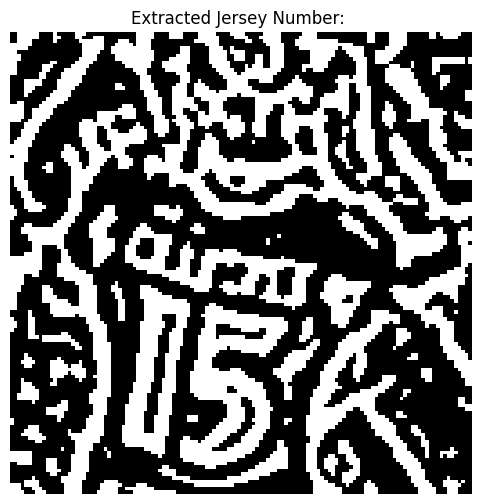

Detected Jersey Number: 


In [10]:
main('/content/nfl_data/train_player_numbers/57583_000082_Endzone_100_V15.png')

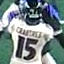

In [11]:
from google.colab.patches import cv2_imshow

image = cv.imread('/content/nfl_data/train_player_numbers/57583_000082_Endzone_100_V15.png')
cv2_imshow(image)

In [12]:
!pip install opencv-python pytesseract matplotlib numpy


In [13]:
# Apply additional preprocessing steps: dilation and erosion to enhance text clarity
kernel = np.ones((2,2), np.uint8)
processed_image = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Perform OCR again with improved preprocessing
extracted_text_refined = pytesseract.image_to_string(processed_image, config='--psm 6')

# Display refined extracted text
extracted_text_refined.strip()

NameError: name 'thresh' is not defined

In [ ]:
# Hysteresis Try
! pip install scipy
import scipy

def gaussian_kernel(size, sigma):
  kernel = np.zeros((size, size))
  k = size // 2

  for i in range(size):
        for j in range(size):
            kernel[i,j] = np.exp(-((i-k)**2 + (j-k)**2)/(2*sigma**2)) / (2*np.pi*sigma**2)

  kernel /= np.sum(kernel)
  return kernel

def gradient(img):
  G = np.zeros(img.shape)
  theta = np.zeros(img.shape)

  k_x = [[-1,0,1],
        [-2,0,2],
        [-1,0,1]]

  k_y = [[1,2,1],
        [0,0,0],
        [-1,-2,-1]]

  x_partial = scipy.ndimage.convolve(img, k_x)
  y_partial = scipy.ndimage.convolve(img, k_y)

  G = np.sqrt(x_partial**2 + y_partial**2)
  theta = np.arctan2(y_partial, x_partial) / (2*np.pi) * 360
  theta = theta % 360

  return G, theta


def nms(G, theta):
  H, W = G.shape
  out = np.zeros((H, W))

  theta = np.floor((theta + 22.5) / 45) * 45
  theta = (theta % 360.0).astype(np.int32)

  for i in range(H):
      for j in range(W):
          if theta[i,j] == 0 or theta[i,j] == 180:
              before = G[i, max(j-1,0)]
              after = G[i, min(j+1,W-1)]

          elif theta[i,j] == 45 or theta[i,j] == (45+180):
              if i-1 < 0 or j-1 < 0:
                  before = 0
              else:
                  before = G[i-1, j-1]
              if i+1 > H-1 or j+1 > W-1:
                  after = 0
              else:
                  after = G[i+1, j+1]

          elif theta[i,j] == 90 or theta[i,j] == (90+180):
              before = G[max(i-1,0), j]
              after = G[min(i+1,H-1), j]

          else:
              if i-1 < 0 or j+1 > W-1:
                  before = 0
              else:
                  before = G[i-1, j+1]

              if i+1 > H-1 or j-1 < 0:
                  after = 0
              else:
                  after = G[i+1, j-1]

          out[i,j] = G[i,j] if max(G[i,j], before, after) == G[i,j] else 0

  return out

def double_thresholding(img, high, low):
    strong_edges = np.zeros(img.shape, dtype=bool)
    weak_edges = np.zeros(img.shape, dtype=bool)

    strong_edges = img > high
    weak_edges = (img > low) * (img <= high)

    return strong_edges, weak_edges

def get_neighbors(y, x, H, W):
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors

def link_edges(strong_edges, weak_edges):
    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=bool)

    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    for r, c in indices:
        Q = []
        Q.append((r, c))

        while Q:
            y, x = Q.pop(0)
            for i, j in get_neighbors(y, x, H, W):
                if weak_edges[i, j] == True:
                    weak_edges[i, j] = False
                    edges[i, j] = True
                    Q.append((i, j))

    edges = cv.normalize(edges.astype(np.uint8), None, 0, 255, cv.NORM_MINMAX)


    return edges

def hysteresis_thresholding(gradient_magnitude, low_threshold, high_threshold):
    """
    Applies hysteresis thresholding to an edge-detected image.

    Parameters:
    - gradient_magnitude: Edge intensity image (e.g., from Sobel or Laplacian)
    - low_threshold: The lower threshold for weak edges
    - high_threshold: The upper threshold for strong edges

    Returns:
    - Final edge-detected binary image
    """
    # Create empty output image
    strong_edges = (gradient_magnitude >= high_threshold).astype(np.uint8) * 255
    weak_edges = ((gradient_magnitude >= low_threshold) & (gradient_magnitude < high_threshold)).astype(np.uint8) * 255

    # Define connectivity kernel (8-connected neighbors)
    kernel = np.array([[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]], dtype=np.uint8)

    # Iterate to connect weak edges to strong edges
    while True:
        # Dilate strong edges
        new_strong = cv.dilate(strong_edges, kernel)

        # Check which weak edges are now connected to strong edges
        new_weak_connected = np.bitwise_and(new_strong, weak_edges)

        # If no more weak edges are connected, stop
        if np.array_equal(new_weak_connected, strong_edges):
            break

        # Update strong edges with newly connected weak edges
        strong_edges = new_weak_connected

    return strong_edges

In [ ]:
# Image pre-processing and edge detection
def canny(img, kernel_size=5, sigma=1.4, high=5, low=1):
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.GaussianBlur(img, (5, 5), 1.5)
  print(f"Image: {img.shape}")

  kernel = gaussian_kernel(kernel_size, sigma)
  print(f"Kernel: {kernel.shape}")

  smoothed = scipy.ndimage.convolve(img, kernel)
  G, theta = gradient(smoothed)
  # non_max = nms(G, theta)
  # strong, weak = double_thresholding(non_max, high, low)
  # edge = link_edges(strong, weak)
  edge = hysteresis_thresholding(G, high, low)

  return edge

In [ ]:
# # Image pre-processing and edge detection
# def canny(img, kernel_size=5, sigma=1.4, high=15, low=6):
#   img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#   img = cv.GaussianBlur(img, (5, 5), 1.5)
#   print(f"Image: {img.shape}")

#   kernel = gaussian_kernel(kernel_size, sigma)
#   print(f"Kernel: {kernel.shape}")

#   smoothed = scipy.ndimage.convolve(img, kernel)
#   G, theta = gradient(smoothed)
#   non_max = nms(G, theta)
#   strong, weak = double_thresholding(non_max, high, low)
#   edge = link_edges(strong, weak)

#   return edge

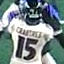

Image: (64, 64)
Kernel: (5, 5)


<Figure size 640x480 with 0 Axes>

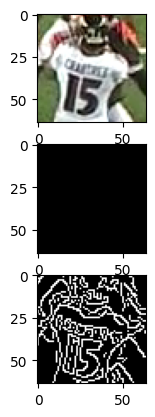

In [ ]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
cv2_imshow( image)

canny_img = canny(image)

right = cv.Canny(image, 100, 200)
#cv2_imshow( right)

# Displaying the input and output image
plt.figure()
f, plots = plt.subplots(3, 1)
plots[0].imshow(image)
plots[1].imshow(canny_img).cmap='gray'
plots[2].imshow(right).cmap='gray'

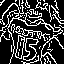

'Ons\nia'

In [ ]:
# Apply additional preprocessing steps: dilation and erosion to enhance text clarity
cv2_imshow( right)

kernel = np.ones((2,2), np.uint8)
processed_image = cv2.morphologyEx(right, cv2.MORPH_CLOSE, kernel)

# Perform OCR again with improved preprocessing
extracted_text_refined = pytesseract.image_to_string(processed_image, config='--psm 6')

# Display refined extracted text
extracted_text_refined.strip()

In [ ]:
!apt-get install -y tesseract-ocr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.4 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [ ]:
!pip install pytesseract
!tesseract --version

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [ ]:
# Apply preprocessing: thresholding and edge enhancement
import cv2
import pytesseract
#cv2_imshow( right)
# Apply preprocessing: thresholding and edge enhancement
_, thresh = cv2.threshold(right, 50, 150, cv2.THRESH_BINARY_INV)

# Perform OCR to extract text
extracted_text = pytesseract.image_to_string(thresh, config='--psm 6')

# Display extracted text
extracted_text.strip()

''